## Определение перспективного тарифа для телеком компании

В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Шаг 1. Изучение общей информации

In [18]:
import pandas as pd #импорт всех необходимых библиотек
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns
import scipy.stats as st
%matplotlib inline

##### Информация о звонках

In [19]:
calls = pd.read_csv('/datasets/calls.csv',parse_dates=[1,]) #создаем датасет о звонках в переменной calls
calls.head(3) #печать первых трек строк

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000


##### Информация об интернет трафике

In [20]:
internet = pd.read_csv('/datasets/internet.csv',parse_dates=[2,]) #создаем датасет об интернет трафике в переменной internet
internet.head(3) #печать первых трек строк

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000


##### Информация о сообщениях

In [21]:
messages = pd.read_csv('/datasets/messages.csv', parse_dates=[1,]) #создаем датасет о сообщениях в переменной messages
messages.head(3) #печать первых трек строк

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000


##### Информация о тарифах

In [22]:
tariffs = pd.read_csv('/datasets/tariffs.csv', parse_dates=[1,]) #создаем датасет о тарифах в переменной tariffs
tariffs.head(3) #печать первых трек строк

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


##### Информация о клиентах

In [23]:
users = pd.read_csv('/datasets/users.csv', parse_dates=[2,-2]) #создаем датасет о клиентах в переменной users
users.head(3) #печать первых трек строк

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaT,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaT,Стерлитамак,Евгений,Абрамович,2018-06-17,smart


<font color='green'>Данные загружены и изучены, отлично.

### Шаг 2. Подготовка данных.

### Работа с датами

In [24]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
# преобразуем все данные, содержащие информацию с датой в нужный нам формат

In [25]:
calls['month'] = calls['call_date'].dt.month
internet['month'] = internet['session_date'].dt.month
messages['month'] = messages['message_date'].dt.month
# добавление месяца в датасет для дальнейшей работы с ним

### Исправление ошибок

#### Работа с зваонками

In [26]:
calls.info() # вывод информации для датасета по звонкам

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 5 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
month        202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 7.7+ MB


In [27]:
calls.nunique() # вывод уникальных значений без учета na-значений

id           202607
call_date       365
duration       2871
user_id         492
month            12
dtype: int64

In [28]:
calls['duration'].describe(percentiles=[0.02,0.2,0.9,0.99]) # посмотрим на звонки дополнительно по процентилям 2% 20% 90% и 99%

count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
2%            0.000000
20%           0.120000
50%           6.000000
90%          14.940000
99%          22.240000
max          38.000000
Name: duration, dtype: float64

Видно, что "2%" целиком состоит из нулевых значений.

In [29]:
calls['duration']= calls['duration'].apply(np.ceil) # округляем значения звонков в большую сторону

In [30]:
calls['duration'].astype('int32') # переводим тип данных в целое

0          0
1          0
2          3
3         14
4          6
          ..
202602     1
202603    19
202604    11
202605     5
202606    20
Name: duration, Length: 202607, dtype: int32

<font color='brown'>Молодец, что не забыл округлить, но теперь данные целочисленные, так что имеет смысл поменять тип.

<b>UPD <font color=brown>Не удалось перевести, здесь нужно делать, как в ячейке выше, приравнивать старый слотлбец новому.

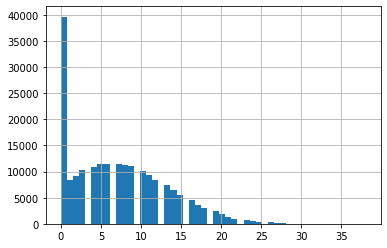

In [31]:
calls['duration'].hist(bins=50) # взглянем на продолжительность звонков

Можно увидеть, что в информации о звонках есть пропуски. Так же много нулевых значений, которые заменю на 1.

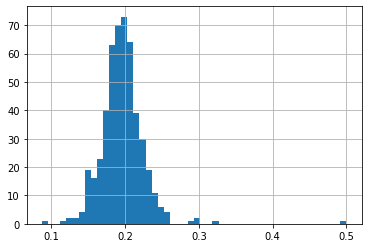

In [32]:
calls.groupby('user_id')['duration'].agg(lambda x: sum(x == 0)/len(x)).hist(bins = 50)

Действительно, "0" в значениях имеют характер нормального распределения, вероятно всего это ошибка в исходных данных.

In [33]:
nuli = calls.query('duration == 0')
("Количество нулевых значений в продолжительности звонка", len(nuli))

('Количество нулевых значений в продолжительности звонка', 39613)

In [34]:
calls.describe()

,duration,user_id,month
count,202607.000000,202607.000000,202607.000000
mean,7.158198,1253.940619,8.574067
std,5.959173,144.722751,2.787093
min,0.000000,1000.000000,1.000000
25%,2.000000,1126.000000,7.000000
50%,6.000000,1260.000000,9.000000
75%,11.000000,1379.000000,11.000000
max,38.000000,1499.000000,12.000000


In [35]:
calls.loc[calls['duration'] == 0, 'duration'] = 1
# замена нулевых значений на 1

При смене нулей на единицу, числовые характеристики нашей таблицы практически не поменялись.

In [36]:
# calls.loc[calls['duration'] == 0, 'duration'] = calls['duration'].mean()

    Для сравнения при смене нулевых значений на среднюю:
- средняя вырастает с 7,15 до 8,55
- станд.отклонение падает с 5,96 до 4,85
- медиана вырастает с 6 до 7,16

      Такой вид изменения нулей сильно изменяет нашу исходную таблицу и в дальнейшем еще сильней исказит результаты анализа. Поэтому логичнее "0" заменить на "1", учитывая что распределение нулей имеет нормальный тип, а не случайный. 

In [37]:
calls.describe() #посмоттрим на результат 

,duration,user_id,month
count,202607.000000,202607.000000,202607.000000
mean,7.353714,1253.940619,8.574067
std,5.733230,144.722751,2.787093
min,1.000000,1000.000000,1.000000
25%,2.000000,1126.000000,7.000000
50%,6.000000,1260.000000,9.000000
75%,11.000000,1379.000000,11.000000
max,38.000000,1499.000000,12.000000


### Работа с интернет траффиком

In [38]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 6 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null object
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
month           149396 non-null int64
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 6.8+ MB


Из цели задачи нас интересует количество использованных МБ интернет трафика, исправим ошибку в столбце, переведя его в числовые значения.

In [39]:
internet['mb_used'] = internet['mb_used'].dropna().astype('float').apply(np.ceil) 
# перевод в числовые значения и округление его в большую сторону

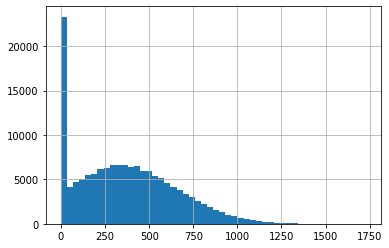

In [40]:
internet['mb_used'].hist(bins = 50) # визуализация использования интернет трафика

Видно, что много нулевых значений, которые стоит заменить на "1".

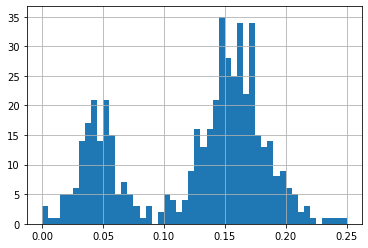

In [41]:
internet.groupby('user_id')['mb_used'].agg(lambda x: sum(x == 0)/len(x)).hist(bins = 50)

По сравнению с продолжительностью звонка, видно "2" пика нормального распределения - скорее всего это связано с наличием двух тарифов.

In [42]:
internet.loc[internet['mb_used'] == 0, 'mb_used'] = 1
internet['mb_used'].astype('int32')
# замена нулевых значений на 1

0          113
1         1053
2         1198
3          551
4          303
          ... 
149391     319
149392     491
149393       1
149394    1247
149395     545
Name: mb_used, Length: 149396, dtype: int32

In [43]:
internet.describe() #посмоттрим на результат 

,Unnamed: 0,mb_used,user_id,month
count,149396.000000,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.753280,1252.099842,8.563315
std,43127.054745,278.212524,144.050823,2.788717
min,0.000000,1.000000,1000.000000,1.000000
25%,37348.750000,139.000000,1130.000000,7.000000
50%,74697.500000,349.000000,1251.000000,9.000000
75%,112046.250000,560.000000,1380.000000,11.000000
max,149395.000000,1725.000000,1499.000000,12.000000


### Подсчет для каждого клиента
- количество сделанных звонков и израсходованных минут разговора по месяцам
- количество отправленных сообщений по месяцам
- объем израсходованного интернет-трафика по месяцам
- помесячную выручку с каждого пользователя

In [44]:
data_temp = []
for i in [internet,messages,calls]:
    data_temp.append(i.groupby(['user_id','month'])['id'].count())
# цикл формирующий таблицу значений количества интернет трафика, 
# сообщений и продолжительности звонков по месяцам для каждого пользователя

In [45]:
pd.concat(data_temp, axis = 1) # объеденяем в общую таблицу полученные значения в buf по оси. 
#Идентификаторы с лева на право интернет трафик, сообщения и звонки соответственно

id    id    id
user_id month                  
1000    5       5.0  22.0  22.0
        6      49.0  60.0  43.0
        7      29.0  75.0  47.0
        8      29.0  81.0  52.0
        9      27.0  57.0  58.0
...             ...   ...   ...
1498    10     59.0  42.0  41.0
1499    9       5.0  11.0   9.0
        10     58.0  48.0  68.0
        11     49.0  59.0  74.0
        12     45.0  66.0  69.0

[3214 rows x 3 columns]

In [46]:
data_mes = messages.groupby(['user_id','month'])['id'].count()
# группируем и считаем отдельно количество сообщений для каждого пользователя по месяцам

In [47]:
data_internet = internet.groupby(['user_id','month'])['mb_used'].sum()
# группируем и считаем отдельно количество интернет трафика для каждого пользователя по месяцам

In [48]:
data_calls = calls.groupby(['user_id','month'])['duration'].sum()
# группируем и считаем отдельно количество продолжительностей звонков для каждого пользователя по месяцам

In [49]:
data = pd.concat((data_mes,data_internet,data_calls),axis = 1)
# объеденяем все в общую таблицу 

In [50]:
data.columns = ['messages','mb_used','duration'] 
# переименоываем столбцы

In [51]:
users.set_index('user_id',inplace=True)
# перезапускаем индексы

In [52]:
data = data.join(users[['tariff','city']])
# присоедением столбцы тарифов и городов

In [53]:
data.head(10)

messages  mb_used  duration tariff       city
user_id month                                               
1000    5          22.0   2257.0     164.0  ultra  Краснодар
        6          60.0  23262.0     187.0  ultra  Краснодар
        7          75.0  14017.0     346.0  ultra  Краснодар
        8          81.0  14072.0     418.0  ultra  Краснодар
        9          57.0  14583.0     478.0  ultra  Краснодар
        10         73.0  14717.0     363.0  ultra  Краснодар
        11         58.0  14769.0     344.0  ultra  Краснодар
        12         70.0   9829.0     341.0  ultra  Краснодар
1001    11          NaN  18460.0     444.0  smart     Москва
        12          NaN  14059.0     430.0  smart     Москва

Есть пропущенные значения, которые заменю на "0".

In [54]:
data.loc[data['duration'].isna(), 'duration'] = 0
data.loc[data['messages'].isna(), 'messages'] = 0
data.loc[data['mb_used'].isna(), 'mb_used'] = 0

In [55]:
data['gb_used'] = data['mb_used']/1024 # добавление в исходную таблицу столбца с использованными Гб
data['gb_used'].apply(np.ceil) # округление в большую сторону 
data['gb_used'].astype('int32') # смена типа на целочисленное

user_id  month
1000     5         2
         6        22
         7        13
         8        13
         9        14
                  ..
1498     10       20
1499     9         1
         10       17
         11       17
         12       12
Name: gb_used, Length: 3214, dtype: int32

In [56]:
data.head(3)

messages  mb_used  duration tariff       city    gb_used
user_id month                                                          
1000    5          22.0   2257.0     164.0  ultra  Краснодар   2.204102
        6          60.0  23262.0     187.0  ultra  Краснодар  22.716797
        7          75.0  14017.0     346.0  ultra  Краснодар  13.688477

Тут я конкретно не понимаю почему не добавляются округленные значения.

In [57]:
#sns.pairplot(data = data,hue = 'tariff') 
# взглянем на распределение количесва смс, интернет трафика и звонков по тарифам

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3214 entries, (1000, 5) to (1499, 12)
Data columns (total 6 columns):
messages    3214 non-null float64
mb_used     3214 non-null float64
duration    3214 non-null float64
tariff      3214 non-null object
city        3214 non-null object
gb_used     3214 non-null float64
dtypes: float64(4), object(2)
memory usage: 344.2+ KB


In [59]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null object
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(6), object(2)
memory usage: 256.0+ bytes


In [60]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [61]:
tariffs['mb_per_month_included'].astype('int32')

0    15360
1    30720
Name: mb_per_month_included, dtype: int32

In [65]:
def revenue(row):
    if row['tariff'] == 'smart':
        if row['messages'] > 50:
            messages_extra = (row['messages'] - 50)*3
        else:
            messages_extra = 0
        if row['duration'] > 500:
            calls_extra = (row['duration'] - 500)*3
        else:
            calls_extra = 0
        if (row['mb_used']/1024) > 15:
            gb_extra = ((row['mb_used']/1024) - 15)*200
        else:
            gb_extra = 0
        total_cost = messages_extra + calls_extra + gb_extra + 550
    if row['tariff'] == 'ultra':
        if row['messages'] > 50:
            messages_extra = (row['messages'] - 50)*1
        else:
            messages_extra = 0
        if row['duration'] > 3000:
            calls_extra = (row['duration'] - 3000)*1
        else:
            calls_extra = 0
        if (row['mb_used']/1024) > 30:
            gb_extra = ((row['mb_used']/1024) - 30)*150
        else:
            gb_extra = 0
        total_cost = messages_extra + calls_extra + gb_extra + 1950
    return total_cost
# функция, которая считает сколько потратил на услуги связи абонент

In [69]:
#код ревьюера
tariffs.loc[0, 'minutes_included']

500

In [46]:
data['revenue'] = data.apply(revenue, axis=1) # применение функции к сводной таблице
# и создание столбца revenue - доход 

In [47]:
data.head(50)

messages  mb_used  duration tariff              city  \
user_id month                                                         
1000    5          22.0   2257.0     164.0  ultra         Краснодар   
        6          60.0  23262.0     187.0  ultra         Краснодар   
        7          75.0  14017.0     346.0  ultra         Краснодар   
        8          81.0  14072.0     418.0  ultra         Краснодар   
        9          57.0  14583.0     478.0  ultra         Краснодар   
        10         73.0  14717.0     363.0  ultra         Краснодар   
        11         58.0  14769.0     344.0  ultra         Краснодар   
        12         70.0   9829.0     341.0  ultra         Краснодар   
1001    11          0.0  18460.0     444.0  smart            Москва   
        12          0.0  14059.0     430.0  smart            Москва   
1002    6           4.0  10878.0     118.0  smart       Стерлитамак   
        7          11.0  17615.0     219.0  smart       Стерлитамак   
        8          13.0  20357.0     294.0  smart       Стерлитамак   
        9           4.0  16724.0     217.0  smart       Стерлитамак   
        10         10.0  13913.0     221.0  smart       Стерлитамак   
        11         16.0  18621.0     250.0  smart       Стерлитамак   
        12         12.0  18147.0     242.0  smart       Стерлитамак   
1003    8          37.0   8572.0     392.0  ultra            Москва   
        9          91.0  12479.0     990.0  ultra            Москва   
        10         83.0  14779.0     866.0  ultra            Москва   
        11         94.0  11369.0     844.0  ultra            Москва   
        12         75.0  10132.0     822.0  ultra            Москва   
1004    5          95.0  13415.0      37.0  ultra       Новокузнецк   
        6         134.0  17621.0     177.0  ultra       Новокузнецк   
        7         181.0  22246.0     137.0  ultra       Новокузнецк   
        8         151.0  28609.0     138.0  ultra       Новокузнецк   
        9         146.0  15130.0     125.0  ultra       Новокузнецк   
        10        165.0  18498.0     153.0  ultra       Новокузнецк   
        11        158.0  15634.0     121.0  ultra       Новокузнецк   
        12        162.0  18041.0     136.0  ultra       Новокузнецк   
1005    1           7.0   2730.0      99.0  smart  Набережные Челны   
        2          38.0   7396.0     470.0  smart  Набережные Челны   
        3          56.0  11120.0     620.0  smart  Набережные Челны   
        4          41.0   9371.0     736.0  smart  Набережные Челны   
        5          42.0   7882.0     606.0  smart  Набережные Челны   
        6          47.0   9879.0     623.0  smart  Набережные Челны   
        7          56.0   7705.0     584.0  smart  Набережные Челны   
        8          64.0   7558.0     626.0  smart  Набережные Челны   
        9          52.0   7030.0     488.0  smart  Набережные Челны   
        10         44.0   7811.0     745.0  smart  Набережные Челны   
        11         51.0  12684.0     562.0  smart  Набережные Челны   
        12         54.0   8685.0     613.0  smart  Набережные Челны   
1006    2           0.0   1399.0      42.0  smart         Ульяновск   
        3           0.0  17318.0     296.0  smart         Ульяновск   
        4           0.0  13963.0     365.0  smart         Ульяновск   
        5           0.0  12992.0     381.0  smart         Ульяновск   
        6           0.0  12399.0     483.0  smart         Ульяновск   
        7           0.0  20008.0     327.0  smart         Ульяновск   
        8           0.0  19335.0     285.0  smart         Ульяновск   
        9           0.0  15554.0     367.0  smart         Ульяновск   

                 gb_used      revenue  
user_id month                          
1000    5       2.204102  1950.000000  
        6      22.716797  1960.000000  
        7      13.688477  1975.000000  
        8      13.742188  1981.000000  
        9      14.241211  1957.000000  
        10     14.372070  1973.000000  
  

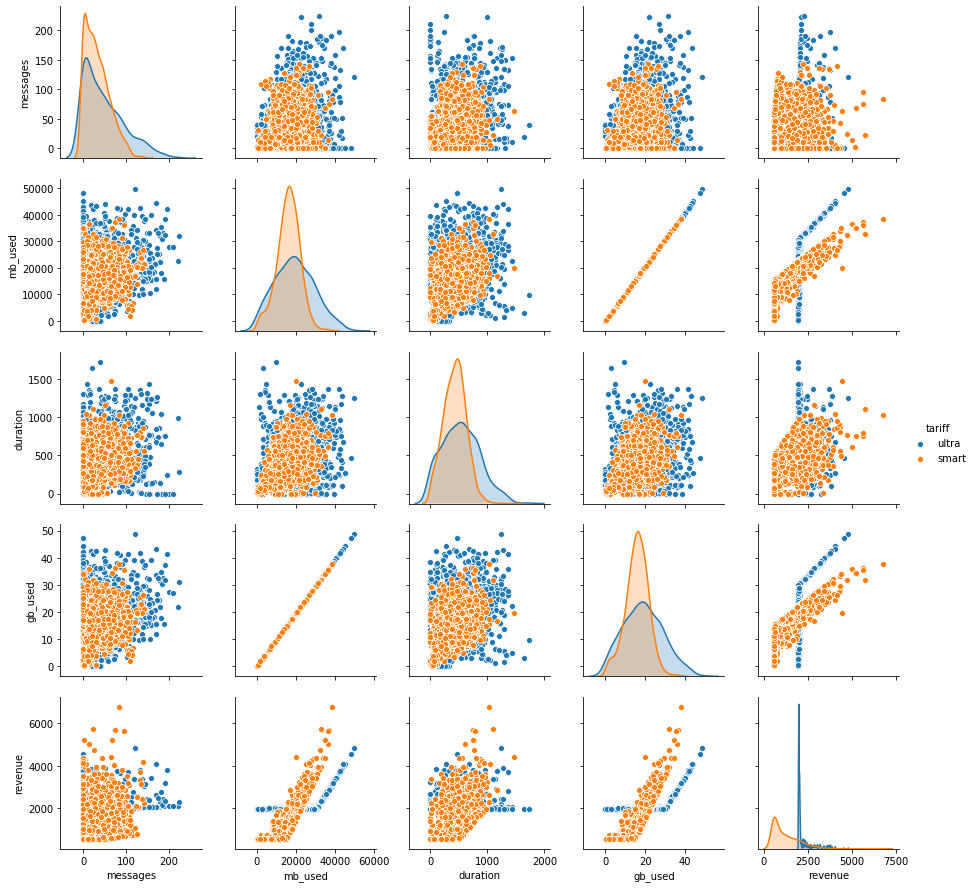

In [48]:
sns.pairplot(data = data,hue = 'tariff') # взглянем на распределение количесва смс, интернет трафика и звонков по тарифам
# по диагонали лежат нас интересующие графики распределения 

#### Посмотрим на медиану, среднюю, дисперсию и стандатрное отклонение по нашей сводной таблице.

In [49]:
stat = data.pivot_table(index=['tariff'], values=['duration', 'mb_used', 'messages', 'revenue'], 
                    aggfunc={'duration': [np.mean, np.median, np.var, np.std], 
                             'mb_used': [np.mean, np.median, np.var, np.std], 
                             'messages': [np.mean, np.median, np.var, np.std],
                             'revenue': [np.mean, np.median, np.var,  np.std]})

In [50]:
stat

duration                                         mb_used           \
              mean median         std            var          mean   median   
tariff                                                                        
smart   429.450875  435.0  194.871174   37974.774628  16237.184388  16540.0   
ultra   540.779695  532.0  325.738740  106105.726823  19488.703553  19324.0   

                                     messages                                 \
                 std           var       mean median        std          var   
tariff                                                                         
smart    5879.795158  3.457199e+07  33.384029   28.0  28.227876   796.812958   
ultra   10097.107541  1.019516e+08  49.363452   38.0  47.804457  2285.266143   

            revenue                                          
               mean       median         std            var  
tariff                                                       
smart   1251.409667   987.664062  797.708109  636338.227423  
ultra   2079.767025  1950.000000  359.854112  129494.982283

<font color='green'>Довольно элегентно.

#### Предварительные выводы
- Пользователи тарифа ultra более разнообразны в расходе смс, интернет трафика и звонков.
- Пользовтали тарифа smart более экономичны и большенство держиться в среднем значении расхода.
- Все графики имеют нормальное распределение.
- Пики средних значений у всех пользователей практически одинаковы.

#### Более подробный анализ кому и чего не хватает?

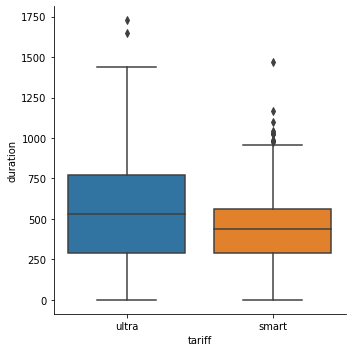

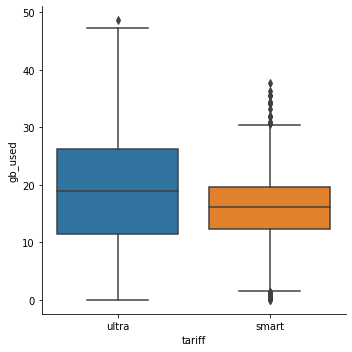

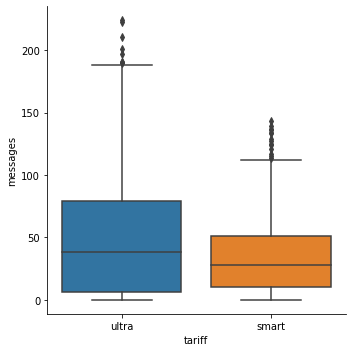

In [73]:
for column in ['duration', 'gb_used', 'messages']:    
    sns.catplot(x="tariff", y=column, kind="box", data=data, orient='v')

Минуты разговора, число сообщений и объем потраченного интернет-трафика по тарифу «Ультра» имеет большую дисперсию по сравнению с тарифом «Смарт», и медианы по вышеперечисленным признакам также смещены в большую сторону. Кроме того, выбросов в рамках более дешевого тарифа существенно больше.

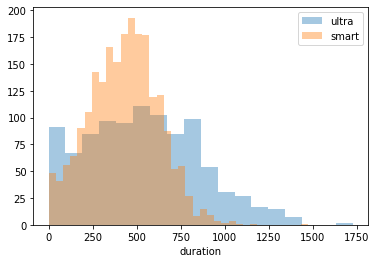

In [75]:
for tariff in ['ultra', 'smart']:
    sns.distplot(data.query('tariff == @tariff')['duration'], kde=False, label=tariff)
_ = plt.legend(['ultra', 'smart'])

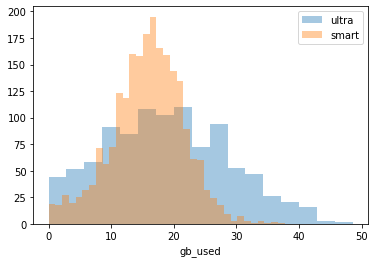

In [76]:
for tariff in ['ultra', 'smart']:
    sns.distplot(data.query('tariff == @tariff')['gb_used'], kde=False)
_ = plt.legend(['ultra', 'smart'])

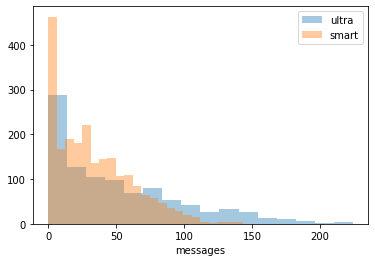

In [77]:
for tariff in ['ultra', 'smart']:
    sns.distplot(data.query('tariff == @tariff')['messages'], kde=False, label=tariff)
_ = plt.legend(['ultra', 'smart'])

По гистограммам наглядно видно, что дисперсия по тарифу "Смарт" меньше, чем у пользователей с тарифом "Ультра" по всем показателям: по длительности разговора, числу сообщений и использованному интернет-трафику. Также на гистограммах видно, что мода у "Смарта" явно выражена.

Другими словами, поведение пользователей тарифа "Ультра" более разнообразное с точки зрения потребления телекоммуникационных услуг. Пользователи дорогого тарифа более свободны в выборе того, как именно использовать объемы тарифного пакета: возможно, использование дорогого тарифа помогает им не думать о том, что в какой-то момент у них отключится интернет или закончится пакет по минутам разговора.

### Шаг 4. Проверьте гипотезы

- средняя выручка пользователей тарифов «Ультра» и «Смарт» различается
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

#### Проверка первой гипотезы
- H0  — средняя выручка пользователей тарифа «Ультра» равна средней выручке пользователей тарифа «Смарт».
- H1 — средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.
- alpha = 5%

In [51]:
ultra = data.query('tariff == "ultra"')['revenue']
smart = data.query('tariff == "smart"')['revenue']
alpha = .05
results = st.ttest_ind(
    ultra, 
    smart, 
    equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 7.50841177869535e-291
Отвергаем нулевую гипотезу


In [52]:
data.pivot_table(index='tariff', values='revenue', aggfunc='mean')

,revenue
tariff,
smart,1251.409667
ultra,2079.767025


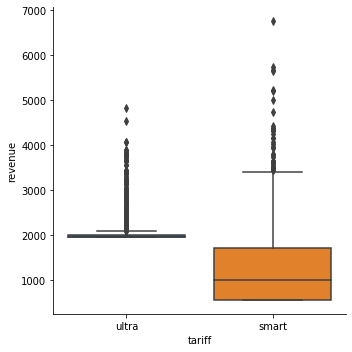

In [53]:
sns.catplot(x="tariff", y='revenue', kind="box", data=data, orient='v')

Средние значения выручки по тарифам различаются почти в 2 раза. Если у пользователя подключен тариф "Смарт" с абонентской платой в 550 рублей, то он скорее всего по итогам месяца заплатит гораздо больше из-за нехватки услуг в рамках тарифного пакета.

### Проверка второй гипотезы
- H0  — средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.
- H1  — средняя выручка пользователей из Москвы отличается от средней выручке пользователей из других регионов.
- alpha=5%

In [54]:
msc = data.query('city == "Москва"')['revenue']
regions = data.query('city != "Москва"')['revenue']

alpha = .05

results = st.ttest_ind(
    msc, 
    regions, 
    equal_var = False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.4634525670733083
Не получилось отвергнуть нулевую гипотезу


In [55]:
def region(city):
    if city == 'Москва': return 'Москва'
    else: return 'Другой регион'

In [56]:
data['region'] = data['city'].apply(region)
data.pivot_table(index='region', values='revenue', aggfunc='mean')

,revenue
region,
Другой регион,1500.517141
Москва,1525.559000


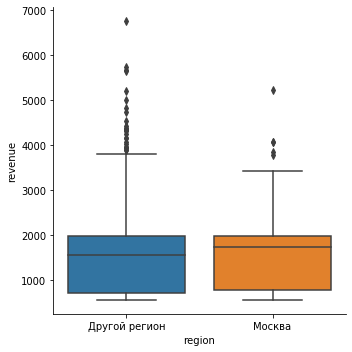

In [57]:
sns.catplot(x="region", y='revenue', kind="box", data=data, orient='v')

Данный статистический тест не дал возможности опровергунть исходную гипотезу о том, что доходы от пользователей из Москвы и из других регионов равны. Действительно, доходы в Московском регионе практически не отличаются от других населенных пунктов.

#### Небольшая ремарка.
    Почему я использовал _ind(то есть посчитал, что выборки незавасимы)
    При смене объекта исследования в первой выборке никак не влияет на выбор объекта во второй выборке. То есть выборки независимы.

### Общие выводы

- По результатам анализа доходов от тарифов «Ультра» и «Смарт» показала, что абоненты платят по разному. Больше платят пользователи "Ультра" 2086 рублей против 1832 рублей в среднем. 

- Стоит отметить, что:
  Пользователям тарифа «Смарт» не хватает услуг в рамках тарифного пакета им приходится доплачивать.

- Средние доходы от пользователей в Москве не отличаются от доходов в других населенных пунктах: разница статистически незначима (p-значение: 0,519) и составляет 27 руб(1888 и 1915).